In [4]:
from time import time
import matplotlib.pyplot as plt
from sksparse.cholmod import cholesky
import scipy
import numpy as np

In [17]:
#nside = 32
#npix =12*nside**2

#matrix_path = '../../PDM/codes/03.FEM_laplacian/HEALPix/'

#A = scipy.sparse.load_npz(matrix_path+'10_matrices/stiffness_matrix_{}.npz'.format(nside))
#B = scipy.sparse.load_npz(matrix_path+'10_matrices/mass_matrix_{}.npz'.format(nside))

A = scipy.sparse.load_npz('matrices/stiffness.npz')
B = scipy.sparse.load_npz('matrices/mass.npz')
reordering_mask = np.load('masks/reordering.npy')

npix = A.shape[0]

A = A[reordering_mask]
B = B[reordering_mask]
A = A[:, reordering_mask]
B = B[:, reordering_mask]

# 1) Sparse Cholesky Decomposition

### 1.1) Measuring the time to decompose the matrix B

In [18]:
t = time()
factor = cholesky(B)
print("Seconds to perform a sparse Cholesky decomposition = ", time()-t)

Seconds to perform a sparse Cholesky decomposition =  0.03573274612426758


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: CholmodTypeConversionWarning: converting matrix of class csr_matrix to CSC format
  


Let's visualize the result of the sparse Cholesky decomposition:

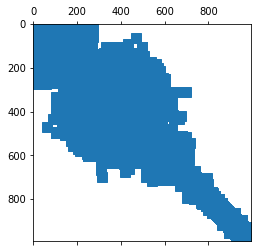

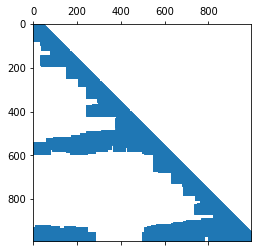

In [21]:
plt.spy(A)
plt.show()
plt.spy(factor.L())

scipy.sparse.save_npz('matrices/cholB', factor.L())

### 1.2) Measuring the time to solve the two sparse triangular systems

In [20]:
b = np.ones(npix)
t = time()
x0 = factor.solve_A(A@b)
print(time()-t)

0.001722574234008789


# 2) Naive solution of the system

In [22]:
B_array = B.toarray()
A_array = A.toarray()
t = time()
x1 = np.linalg.solve(B_array,A_array@b)
print(time()-t)

0.06447958946228027


The solutions obtained with the two methods are actually almost the same:

In [8]:
np.linalg.norm(x0-x1)

7.046685491851902e-11

# 3) Tensorflow implementation (full Cholesky decomposition)

In [9]:
import tensorflow as tf

/Users/Mart/anaconda3/envs/scikits-sparse/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/Mart/anaconda3/envs/scikits-sparse/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/Mart/anaconda3/envs/scikits-sparse/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/Users/Mart/anaconda3/env

In [10]:
RHS = np.random.rand(npix,1) 
t = time()
chol = tf.cholesky(A_array)  # shape 10 x 2 x 2
print(time()-t)

23.196383714675903


In [11]:
t = time()
X = tf.cholesky_solve(chol, RHS)
print(time()-t)
# tf.matmul(A, X) ~ RHS
X  # Solution to the linear system A x = RHS

0.015423774719238281


<tf.Tensor 'cholesky_solve/MatrixTriangularSolve_1:0' shape=(12288, 1) dtype=float64>